# COVID VAX AE Analysis by NLP

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt

!pip install wordcloud
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/m210842/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /Users/m210842/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/m210842/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


     |████████████████████████████████| 225kB 1.8MB/s eta 0:00:01
  Stored in directory: /Users/m210842/Library/Caches/pip/wheels/bf/18/33/c6d0e1bb532e0587da731a02d990e62c483c8e49741e0c4bf3
Successfully built wordcloud


# Load data

In [6]:
df = pd.read_csv('2020_2021April_VAERS_COVID_AE.csv', error_bad_lines=False, encoding='cp1252')
df.rename(columns = {'VAX_NAME|||VAERS_ID': 'VAX_NAME'}, inplace=True)
print(type(df))
print(df.shape)
print(df.columns)

b'Skipping line 12: expected 68 fields, saw 96\nSkipping line 63: expected 68 fields, saw 74\nSkipping line 98: expected 68 fields, saw 74\nSkipping line 143: expected 68 fields, saw 85\nSkipping line 159: expected 68 fields, saw 85\nSkipping line 168: expected 68 fields, saw 74\nSkipping line 173: expected 68 fields, saw 74\nSkipping line 210: expected 68 fields, saw 74\nSkipping line 212: expected 68 fields, saw 74\nSkipping line 214: expected 68 fields, saw 107\nSkipping line 216: expected 68 fields, saw 74\nSkipping line 225: expected 68 fields, saw 74\nSkipping line 242: expected 68 fields, saw 74\nSkipping line 262: expected 68 fields, saw 74\nSkipping line 267: expected 68 fields, saw 74\nSkipping line 271: expected 68 fields, saw 74\nSkipping line 277: expected 68 fields, saw 74\nSkipping line 278: expected 68 fields, saw 74\nSkipping line 302: expected 68 fields, saw 96\nSkipping line 328: expected 68 fields, saw 85\nSkipping line 390: expected 68 fields, saw 74\nSkipping line

<class 'pandas.core.frame.DataFrame'>
(44226, 68)
Index(['VAERS_ID', 'RECVDATE', 'STATE', 'AGE_YRS', 'CAGE_YR', 'CAGE_MO', 'SEX',
       'RPT_DATE', 'SYMPTOM_TEXT', 'DIED', 'DATEDIED', 'L_THREAT', 'ER_VISIT',
       'HOSPITAL', 'HOSPDAYS', 'X_STAY', 'DISABLE', 'RECOVD', 'VAX_DATE',
       'ONSET_DATE', 'NUMDAYS', 'LAB_DATA', 'V_ADMINBY', 'V_FUNDBY',
       'OTHER_MEDS', 'CUR_ILL', 'HISTORY', 'PRIOR_VAX', 'SPLTTYPE',
       'FORM_VERS', 'TODAYS_DATE', 'BIRTH_DEFECT', 'OFC_VISIT', 'ER_ED_VISIT',
       'ALLERGIES|||VAERS_ID', 'VAX_TYPE', 'VAX_MANU', 'VAX_LOT',
       'VAX_DOSE_SERIES', 'VAX_ROUTE', 'VAX_SITE', 'VAX_NAME', 'SYMPTOM1',
       'SYMPTOMVERSION1', 'SYMPTOM2', 'SYMPTOMVERSION2', 'SYMPTOM3',
       'SYMPTOMVERSION3', 'SYMPTOM4', 'SYMPTOMVERSION4', 'SYMPTOM5',
       'SYMPTOMVERSION5', 'SYMPTOM6', 'SYMPTOMVERSION6', 'SYMPTOM7',
       'SYMPTOMVERSION7', 'SYMPTOM8', 'SYMPTOMVERSION8', 'SYMPTOM9',
       'SYMPTOMVERSION9', 'SYMPTOM10', 'SYMPTOMVERSION10', 'SYMPTOM11',
       'SYMP

In [47]:
df.columns

Index(['VAERS_ID', 'RECVDATE', 'STATE', 'AGE_YRS', 'CAGE_YR', 'CAGE_MO', 'SEX',
       'RPT_DATE', 'SYMPTOM_TEXT', 'DIED', 'DATEDIED', 'L_THREAT', 'ER_VISIT',
       'HOSPITAL', 'HOSPDAYS', 'X_STAY', 'DISABLE', 'RECOVD', 'VAX_DATE',
       'ONSET_DATE', 'NUMDAYS', 'LAB_DATA', 'V_ADMINBY', 'V_FUNDBY',
       'OTHER_MEDS', 'CUR_ILL', 'HISTORY', 'PRIOR_VAX', 'SPLTTYPE',
       'FORM_VERS', 'TODAYS_DATE', 'BIRTH_DEFECT', 'OFC_VISIT', 'ER_ED_VISIT',
       'ALLERGIES|||VAERS_ID', 'VAX_TYPE', 'VAX_MANU', 'VAX_LOT',
       'VAX_DOSE_SERIES', 'VAX_ROUTE', 'VAX_SITE', 'VAX_NAME', 'SYMPTOM1',
       'SYMPTOMVERSION1', 'SYMPTOM2', 'SYMPTOMVERSION2', 'SYMPTOM3',
       'SYMPTOMVERSION3', 'SYMPTOM4', 'SYMPTOMVERSION4', 'SYMPTOM5',
       'SYMPTOMVERSION5', 'SYMPTOM6', 'SYMPTOMVERSION6', 'SYMPTOM7',
       'SYMPTOMVERSION7', 'SYMPTOM8', 'SYMPTOMVERSION8', 'SYMPTOM9',
       'SYMPTOMVERSION9', 'SYMPTOM10', 'SYMPTOMVERSION10', 'SYMPTOM11',
       'SYMPTOMVERSION11', 'SYMPTOM12', 'SYMPTOMVERSION12', 'S

## Pre-processing symptoms

In [7]:
sym = df[['VAERS_ID','SYMPTOM_TEXT','VAX_NAME']]
sym = sym.dropna()
sym['SYMPTOM_TEXT'] = sym['SYMPTOM_TEXT'].str.lower()

stop_words_list = stopwords.words("english")
def text_clean(text):
    #All html tags and attributes (i.e., /<[^>]+>/) are removed
    regex_pattern = re.compile('[^A-Za-z0-9\s-]')
    text = re.sub(regex_pattern, ' ', text)
    #Remove duplicate spaces and strp front and end spaces
    text = re.sub(' +',' ',text)
    text = text.strip()
    #make text to a list of words
    text_list = text.split(' ')
    # All stop words are removed. Be clear in what you consider as a stop word.
    text_drop_stop_words_list = [x for x in text_list if x not in stop_words_list]
    #Reconstruct the list to string by adding space in between
    text = " ".join(text_drop_stop_words_list)
    return text


sym['SYMPTOM_TEXT'] = sym['SYMPTOM_TEXT'].apply(text_clean)
sym['SYMPTOM_TEXT'] = sym['SYMPTOM_TEXT'].apply(lambda x: WordNetLemmatizer().lemmatize(x,'v'))
sym = sym.dropna()
sym.head()

,VAERS_ID,SYMPTOM_TEXT,VAX_NAME
0,916600,right side epiglottis swelled hinder swallowin...,COVID19 (COVID19 (MODERNA))|||0916600
1,916601,approximately 30 min post vaccination administ...,COVID19 (COVID19 (MODERNA))|||0916601
2,916602,15 minutes receiving vaccine patient complaine...,COVID19 (COVID19 (PFIZERBIONTECH))|||0916602
3,916603,extreme fatigue dizziness could lift left arm ...,COVID19 (COVID19 (MODERNA))|||0916603
4,916604,injection site swelling redness warm touch itchy,COVID19 (COVID19 (MODERNA))|||0916604


## Pre-processing vaccination

In [9]:
#Define the keywords related to those three vaccines
vacc_key_map = dict()
vacc_key_map['pfizer'] = ['pfizer', 'pfizerbiontech']
vacc_key_map['moderna'] = ['moderna']
vacc_key_map['jj'] = ['johnson', 'jj', 'janssen']

#The function used to determine type of vaccine
def which_vax(text):
    counter = dict()
    counter['pfizer'] = 0
    counter['moderna'] = 0
    counter['jj'] = 0
    text_list = text.split(' ')
    for word in text_list:
        for key in vacc_key_map:
            if word in vacc_key_map[key]:
                counter[key] +=1
                continue
    all_vals = counter.values()
    if max(all_vals) == 0:
        return 'None/Others'
    else:
        return max(counter, key=counter.get)
    
#Add a colummn to for type of vaccine
sym['VAX_NAME'] = sym['VAX_NAME'].str.lower()
sym['VAX_NAME'] = sym['VAX_NAME'].apply(text_clean)
sym['vacc_type'] = sym['VAX_NAME'].apply(lambda x: which_vax(x))

sym.head()

,VAERS_ID,SYMPTOM_TEXT,VAX_NAME,vacc_type
0,916600,right side epiglottis swelled hinder swallowin...,covid19 covid19 moderna 0916600,moderna
1,916601,approximately 30 min post vaccination administ...,covid19 covid19 moderna 0916601,moderna
2,916602,15 minutes receiving vaccine patient complaine...,covid19 covid19 pfizerbiontech 0916602,pfizer
3,916603,extreme fatigue dizziness could lift left arm ...,covid19 covid19 moderna 0916603,moderna
4,916604,injection site swelling redness warm touch itchy,covid19 covid19 moderna 0916604,moderna


## Pre-processing AEs

In [11]:
sym_list = pd.read_csv('AEs.csv')
print(sym_list.shape)
symptoms = list(sym_list['Adverse events'].str.lower())
#print(symptoms)

symptoms_counter = dict()
for key in symptoms:
    if key not in symptoms_counter:
        symptoms_counter[key] = 0
        
#loop through the dataset and count what kind of AE is mentioned most
for symptom in symptoms_counter:
    for c_abs in sym['SYMPTOM_TEXT']:
        if symptom in c_abs:
            symptoms_counter[symptom] += 1
            
#sort the dictionary from highest value to lowest
symptoms_counter=sorted(symptoms_counter.items(),key=lambda x:x[1],reverse=True)

#Only keep the first 10 symptoms
symptoms_counter=dict(symptoms_counter[:10])

#resort the dictionary since the above step break the order
symptoms_counter=sorted(symptoms_counter.items(),key=lambda x:x[1],reverse=True)
symptoms_counter=dict(symptoms_counter)

(23, 1)


# Visualize the data

## AE frequency

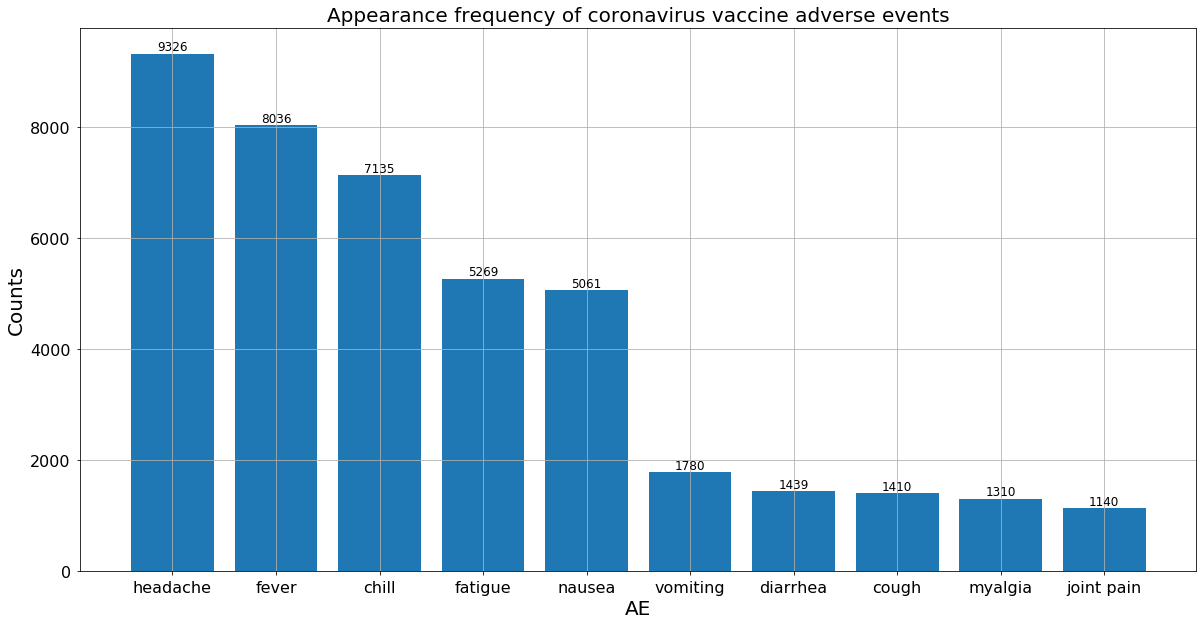

In [16]:
#plot histogram of top 10 coronavirus related symptoms 
#with highest appearance frequency
plt.figure(figsize=(20,10))

x = list(range(len(symptoms_counter)))
y = list(symptoms_counter.values())
plt.bar(x, y, align='center')
plt.xticks(range(len(symptoms_counter)),list(symptoms_counter.keys()))
plt.title('Appearance frequency of coronavirus vaccine adverse events',
          fontdict={'size':20})
plt.xlabel('AE',fontsize=20)
plt.ylabel('Counts',fontsize=20)
ax=plt.gca()
ind=0

for i in x:
    plt.text(i, y[i], '%d' % y[i],
             va='bottom', ha='center', 
             fontdict={'fontsize': 12})
    
ax.grid()
plt.tick_params(labelsize=16, pad=6)
plt.show()

## Visualize vax

In [17]:
sym['sym_split'] = sym['SYMPTOM_TEXT'].str.split()
sym.head()

,VAERS_ID,SYMPTOM_TEXT,VAX_NAME,vacc_type,sym_split
0,916600,right side epiglottis swelled hinder swallowin...,covid19 covid19 moderna 0916600,moderna,"[right, side, epiglottis, swelled, hinder, swa..."
1,916601,approximately 30 min post vaccination administ...,covid19 covid19 moderna 0916601,moderna,"[approximately, 30, min, post, vaccination, ad..."
2,916602,15 minutes receiving vaccine patient complaine...,covid19 covid19 pfizerbiontech 0916602,pfizer,"[15, minutes, receiving, vaccine, patient, com..."
3,916603,extreme fatigue dizziness could lift left arm ...,covid19 covid19 moderna 0916603,moderna,"[extreme, fatigue, dizziness, could, lift, lef..."
4,916604,injection site swelling redness warm touch itchy,covid19 covid19 moderna 0916604,moderna,"[injection, site, swelling, redness, warm, tou..."


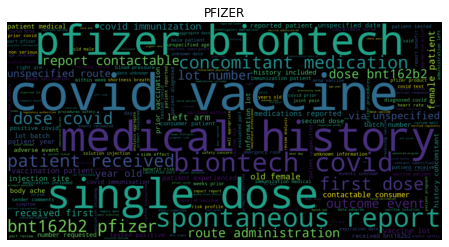

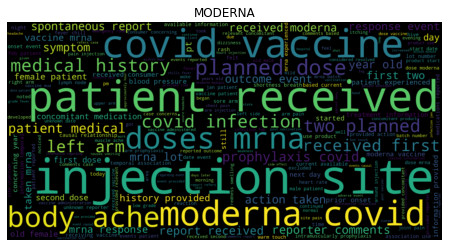

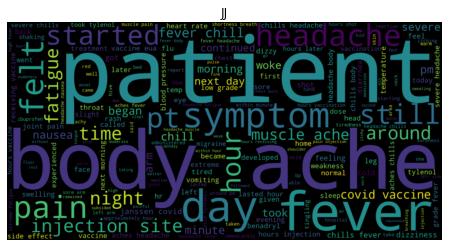

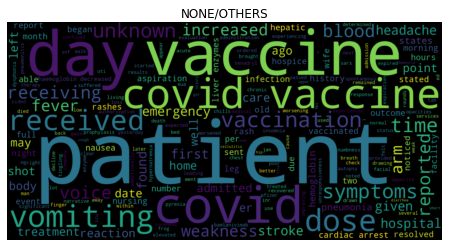

In [19]:
vax_types = [
    'pfizer', 
    'moderna',
    'jj',
    'None/Others'
]
for vax_type in vax_types:
    sym_words = sym[sym['vacc_type'] == vax_type]['sym_split'].apply(
        lambda x: ' '.join(x)
    )
    sym_words_wc = " ".join(sym_words)
    
    # create a word cloud
    wc = WordCloud(
        width=2000, height=1000, max_words=200,
        background_color='black'
    ).generate(sym_words_wc)
    
    # show
    plt.figure(figsize=(8, 4))
    plt.imshow(wc, interpolation='bilinear')
    plt.title('%s' % (vax_type.upper()))
    plt.axis('off')
    plt.show()

# Data Generator

In [20]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

In [30]:
class DataGenerator(object):
    def __init__(self, df):
        super().__init__()
        self.df = df
    
    def generate(self, feature_column, label_column, method='tf-idf', top=1000):
        if method == 'tf-idf':
            return self._generate_tf_idf(feature_column, label_column)
        
        elif method == 'wf':
            return self._generate_wf(feature_column, label_column)
        
        else:
            raise Exception('UNKNOWN method %s' % method)
            
    def _generate_wf(self, feature_column, label_column):
        cnt_vec = CountVectorizer(stop_words='english')
        X = cnt_vec.fit_transform(
            self.df[feature_column].apply(lambda x: ' '.join(x))
        )
        y = self.df[label_column]
        return X, y, cnt_vec
        
    def _generate_tf_idf(self, feature_column, label_column):
        tfidf_vec = TfidfVectorizer(stop_words='english')
        X = tfidf_vec.fit_transform(
            self.df[feature_column].apply(lambda x: ' '.join(x))
        )
        y = self.df[label_column]
        return X, y, tfidf_vec
    
    def split_data(self, X, y, percent=[0.7, 0.3], random_state=42):
        if len(percent) == 2:
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=percent[1],
                random_state=random_state
            )
            return X_train, X_test, y_train, y_test
            
        elif len(percent) == 3:
            print('* Train %.2f + Test %.2f + Validation %.2f split' % (
                percent[0], percent[1], percent[2]
            ))
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=percent[1],
                random_state=random_state
            )
            # split the train into valid
            X_train, X_valid, y_train, y_valid = train_test_split(
                X_train, y_train, test_size=percent[2]/(1-percent[1]),
                random_state=random_state
            )
            return X_train, X_valid, X_test, y_train, y_valid, y_test
        
        else:
            raise Exception('WRONG percent %s' % percent)
            

# Classifier

In [22]:
from collections import OrderedDict

from sklearn.linear_model import LogisticRegression as lr
from sklearn.naive_bayes import BernoulliNB as bnb
from sklearn.naive_bayes import MultinomialNB as mnb
from sklearn.svm import LinearSVC as lsvc
from sklearn.ensemble import RandomForestClassifier as rf
from sklearn.calibration import CalibratedClassifierCV 
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score,roc_curve,auc

In [39]:
class Classifier(object):
    def __init__(self, X_train, y_train):
        super().__init__()
        
        self.X_train = X_train
        self.y_train = y_train
        
        self.models = OrderedDict([
            ('LR', [lr(C=1.0), dict(C=np.arange(0.1, 3, 0.2))]),
            ('MNB', [mnb(alpha=5.0), dict(alpha=np.arange(0.1, 10, 1))]),
            ('BNB', [bnb(alpha=5.0), dict(alpha=np.arange(0.1, 10, 1))]),
            ('LSVC', [lsvc(C=0.1), dict(C=np.arange(0.1, 3, 0.2))]),
            ('RF', [rf(n_estimators=40, random_state=0), dict(n_estimators=np.arange(10, 50, 10))])
        ])
        
    def train_model(self, model_name, is_tune_hyper=False, hyper_params=''):
        model = self.models[model_name][0]
        
        if model_name == 'LSVC' and is_tune_hyper == False:
            model = CalibratedClassifierCV(model)
            
        if is_tune_hyper:
            if not hyper_params:
                hyper_params = self.models[model_name][1]
                
            # grid search for the hyper params
            grid = GridSearchCV(model, hyper_params, cv=5, scoring='accuracy', n_jobs=-1)
            
            # fit the grid
            grid.fit(self.X_train, self.y_train)
            print('* Found best %s for %s thru 5-cross, params: %s' % (
                model_name, grid.best_score_, grid.best_params_
            ))
            
            # get the best model
            best_model = grid.best_estimator_
            
        else:
            best_model = model.fit(self.X_train, self.y_train)
            
        y_train_pred = best_model.predict(self.X_train)
        acc = accuracy_score(self.y_train, y_train_pred)
        print('* predicted %s train accuracy: %s' % (
            model_name, acc
        ))
        
        return best_model, acc
    
    def test_model(self, best_model, X_test, y_test, is_report=False, model_name=''):
        y_test_pred = best_model.predict(X_test)
        
        acc = accuracy_score(y_test, y_test_pred)
        cm = confusion_matrix(y_test, y_test_pred)
        
        print('* predicted %s test accuracy: %s' % (
            model_name, acc
        ))
        
        if is_report:
            print('Test report:\n')
            print(classification_report(y_test, y_test_pred))
            print('')
            
            if len(set(y_test))==2 and model_name != 'LSVC':
                y_score = best_model.predict_proba(X_test)
                print('* ROC and AUC:\n')
                self.plot_roc(y_test, y_score)
            
            elif len(set(y_test))>2:
                self.plot_cm(cm)
                
        return acc, cm
    
    
    def plot_roc(self, y_t, score):
        preds = score[:, 1]
        fpr, tpr, threshold = roc_curve(y_t, preds)
        roc_auc = auc(fpr, tpr)
        plt.title('Receiver Operating Characteristic')
        plt.plot(fpr,tpr,'b',label='AUC =%0.2f'%roc_auc)
        plt.legend(loc='lower right')
        plt.plot([0,1],[0,1],'r--')
        plt.xlim([0,1])
        plt.ylim([0,1])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    def plot_cm(self, cm):
        # plot the confusion matrix
        plt.figure(figsize=(8,8))
        plt.matshow(cm,fignum=1)
        ax=plt.gca()
        virus_type=['pfizer','moderna','jj','None/Others']
        ax.set_xticklabels(['']+virus_type)
        ax.set_yticklabels(['']+virus_type)
        plt.show()

# Test on data

## Create dataset

In [31]:
AE_Gner = DataGenerator(sym)
df_X, df_y, df_feature = AE_Gner.generate(
    'sym_split', 'vacc_type', 'tf-idf'
)

df_X_train, df_X_test, df_y_train, df_y_test = AE_Gner.split_data(
    df_X, df_y, percent=[0.7, 0.3]
)

## Createa a classifier

In [41]:
aeclsfer = Classifier(df_X_train, df_y_train)

## Train LR model and test

* Found best LR for 0.6876211396821295 thru 5-cross, params: {'C': 2.3000000000000007}
* predicted LR train accuracy: 0.7833376405220313
* predicted LR test accuracy: 0.6976183298160988
Test report:



/Users/m210842/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

 None/Others       0.00      0.00      0.00         6
          jj       0.63      0.24      0.35       815
     moderna       0.68      0.66      0.67      5592
      pfizer       0.71      0.78      0.75      6855

    accuracy                           0.70     13268
   macro avg       0.51      0.42      0.44     13268
weighted avg       0.69      0.70      0.69     13268




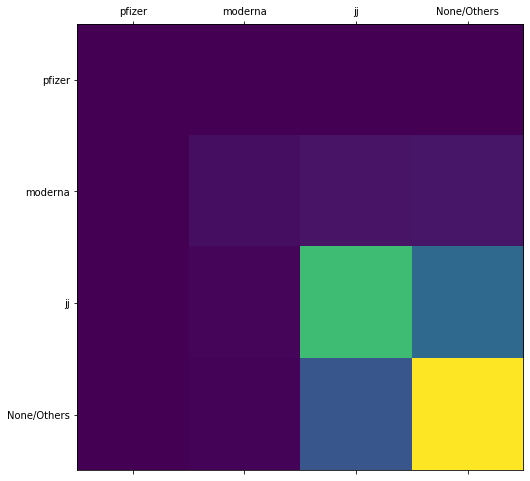

In [42]:
model_name = 'LR'
model_lr, _ = aeclsfer.train_model(model_name, True)
rst_lr = aeclsfer.test_model(model_lr, df_X_test, df_y_test, True, model_name)

## Train MNB model and test

* Found best MNB for 0.651634578110867 thru 5-cross, params: {'alpha': 1.1}
* predicted MNB train accuracy: 0.7066804496705
* predicted MNB test accuracy: 0.6568435333132349
Test report:



/Users/m210842/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

 None/Others       0.00      0.00      0.00         6
          jj       0.00      0.00      0.00       815
     moderna       0.62      0.66      0.64      5592
      pfizer       0.69      0.73      0.71      6855

    accuracy                           0.66     13268
   macro avg       0.33      0.35      0.34     13268
weighted avg       0.62      0.66      0.64     13268




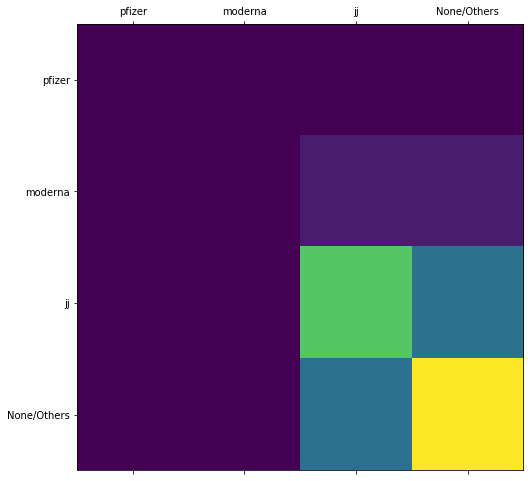

In [43]:
model_name = 'MNB'
model_mnb, _ = aeclsfer.train_model(model_name, True)
rst_lr = aeclsfer.test_model(model_mnb, df_X_test, df_y_test, True, model_name)

## Train LSVC model and test

* Found best LSVC for 0.6855213851918852 thru 5-cross, params: {'C': 0.1}
* predicted LSVC train accuracy: 0.7569776456906577
* predicted LSVC test accuracy: 0.6968646367199276
Test report:



/Users/m210842/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

 None/Others       0.00      0.00      0.00         6
          jj       0.74      0.18      0.29       815
     moderna       0.68      0.65      0.67      5592
      pfizer       0.70      0.79      0.75      6855

    accuracy                           0.70     13268
   macro avg       0.53      0.41      0.43     13268
weighted avg       0.70      0.70      0.69     13268




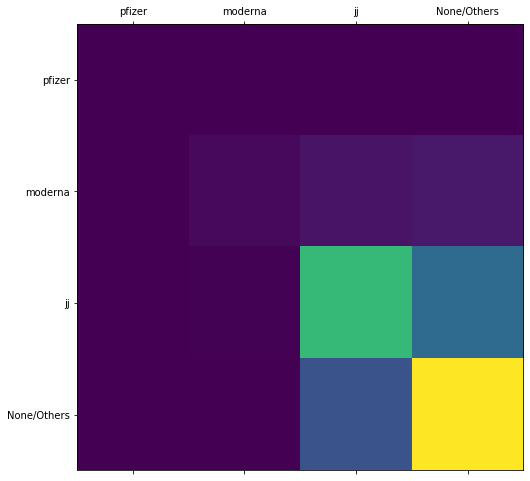

In [44]:
model_name = 'LSVC'
model_lsvc, _ = aeclsfer.train_model(model_name, True)
rst_lsvc = aeclsfer.test_model(model_lsvc, df_X_test, df_y_test, True, model_name)

## Train RF model and test

* Found best RF for 0.6751841323168368 thru 5-cross, params: {'n_estimators': 40}
* predicted RF train accuracy: 0.9893720118878409
* predicted RF test accuracy: 0.6811124510099488
Test report:

              precision    recall  f1-score   support

 None/Others       0.00      0.00      0.00         6
          jj       0.71      0.10      0.18       815
     moderna       0.65      0.67      0.66      5592
      pfizer       0.70      0.76      0.73      6855

    accuracy                           0.68     13268
   macro avg       0.52      0.38      0.39     13268
weighted avg       0.68      0.68      0.67     13268




/Users/m210842/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


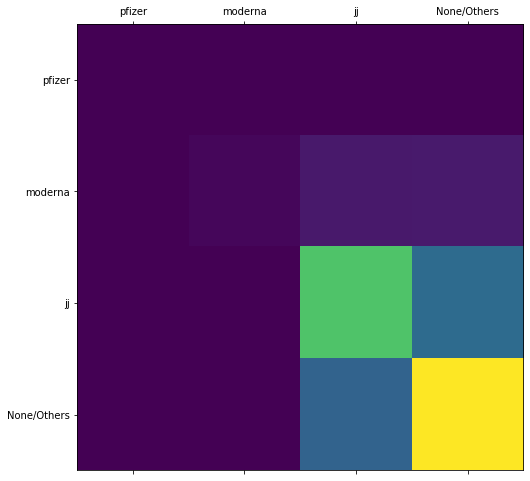

In [45]:
model_name = 'RF'
model_rf, _ = aeclsfer.train_model(model_name, True)
rst_rf = aeclsfer.test_model(model_rf, df_X_test, df_y_test, True, model_name)